In [1]:
import os
import pandas as pd
import numpy as np
from dplython import (DplyFrame, X, diamonds, select, sift, sample_n, sample_frac, arrange, mutate, group_by, summarize)

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config IPCompleter.greedy=True

# set some plotting aesthetics, similar to ggplot
sns.set(palette = "colorblind", font_scale = 1.35, rc = {"figure.figsize": (10,6), "axes.facecolor": ".92"})

out_dir = '/Users/genie/dev/projects/github/got_survival_analysis/out'
os.chdir(out_dir)

/anaconda3/envs/dev2/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
data_path = '/Users/genie/dev/projects/github/got_survival_analysis/data/got_characters_s1_to_s7.csv'
character_df = pd.read_csv(data_path,quotechar='"',na_values='',encoding = "ISO-8859-1")

In [3]:
character_df['total_screen_time'] = character_df.apply(lambda x: sum([x['s'+str(i)+'_screenTime'] for i in range(1,8)]), axis=1)
character_df['num_of_episodes_appeared'] = character_df.apply(lambda x: sum([x['s'+str(i)+'_episodes'] for i in range(1,8)]), axis=1)
character_df['num_of_people_killed'] = character_df.apply(lambda x: sum([x['s'+str(i)+'_numKilled'] for i in range(1,8)]), axis=1)

character_df['spouse'] = character_df['spouse'].fillna('') 
character_df['is_married'] = character_df.apply(lambda x: (0 if x['spouse']=='' else 1), axis=1)

character_df['siblings'] = character_df['siblings'].fillna('') 
character_df['have_siblings'] = character_df.apply(lambda x: (0 if x['siblings']=='' else 1), axis=1)                                                

character_df['parent_of'] = character_df['parent_of'].fillna('') 
character_df['have_children'] = character_df.apply(lambda x: (0 if x['parent_of']=='' else 1), axis=1)                                                

# remove unwanted variables
character_df = character_df.drop(['s'+str(i)+'_screenTime' for i in range(1,8)], axis=1)
character_df = character_df.drop(['s'+str(i)+'_shareOfScreenTime' for i in range(1,8)], axis=1)
character_df = character_df.drop(['s'+str(i)+'_episodes' for i in range(1,8)], axis=1)
character_df = character_df.drop(['s'+str(i)+'_numKilled' for i in range(1,8)], axis=1)
character_df = character_df.drop(['s'+str(i)+'_numOfCharactersInteractedWith' for i in range(1,8)], axis=1)
character_df = character_df.drop(['spouse','parents','siblings','parent_of','manner_of_death','killed_by','dead_in_season'], axis=1)
                                                                                 

In [4]:
character_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 27 columns):
character_name              368 non-null object
gender                      147 non-null object
house                       86 non-null object
royal                       368 non-null int64
kingsguard                  368 non-null int64
s1_bc                       368 non-null float64
s1_ec                       368 non-null float64
s2_bc                       368 non-null float64
s2_ec                       368 non-null float64
s3_bc                       368 non-null float64
s3_ec                       368 non-null float64
s4_bc                       368 non-null float64
s4_ec                       368 non-null float64
s5_bc                       368 non-null float64
s5_ec                       368 non-null float64
s6_bc                       368 non-null float64
s6_ec                       368 non-null float64
s7_bc                       368 non-null float64
s7_ec                

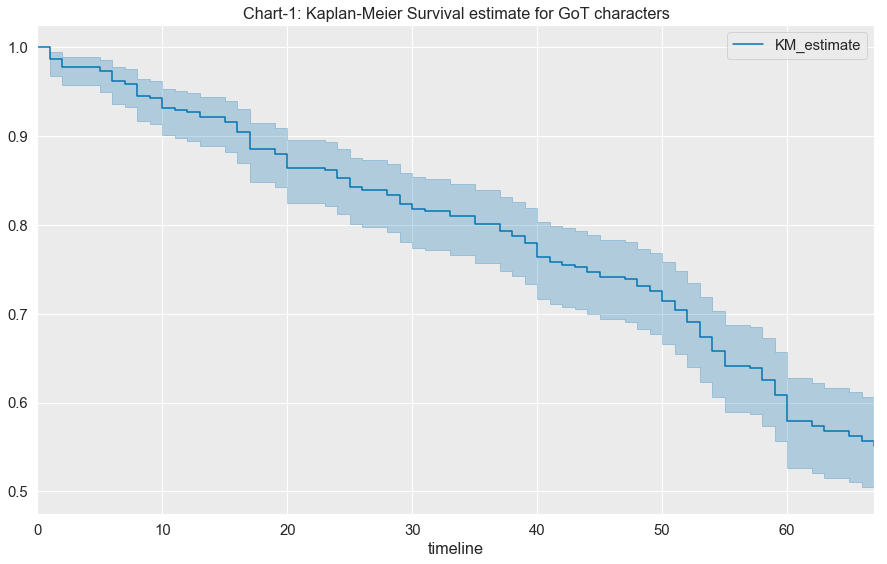

In [20]:
kmf = KaplanMeierFitter()
kmf.fit(durations = character_df.duration_in_episodes, event_observed = character_df.is_dead)
ax = kmf.plot_survival_function()
ax.set_title('Chart-1: Kaplan-Meier Survival estimate for GoT characters')
ax.get_figure().savefig("chart1.png")

In [6]:
# kmf.event_table

In [7]:
kmf.predict(67)

0.5516304347826084

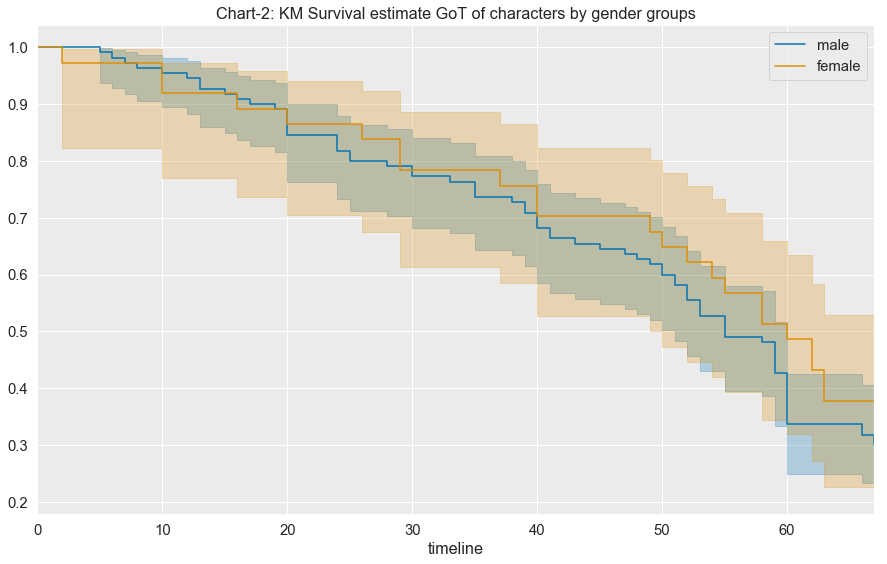

In [21]:
groups = character_df['gender']
g1 = (groups == 'male')
g2 = (groups == 'female')

kmf = KaplanMeierFitter()
kmf.fit(character_df['duration_in_episodes'][g1], character_df['is_dead'][g1], label='male')
ax = kmf.plot()

kmf.fit(character_df['duration_in_episodes'][g2], character_df['is_dead'][g2], label='female')
ax = kmf.plot(ax=ax)
ax.set_title('Chart-2: KM Survival estimate GoT of characters by gender groups')
ax.get_figure().savefig("chart2.png")

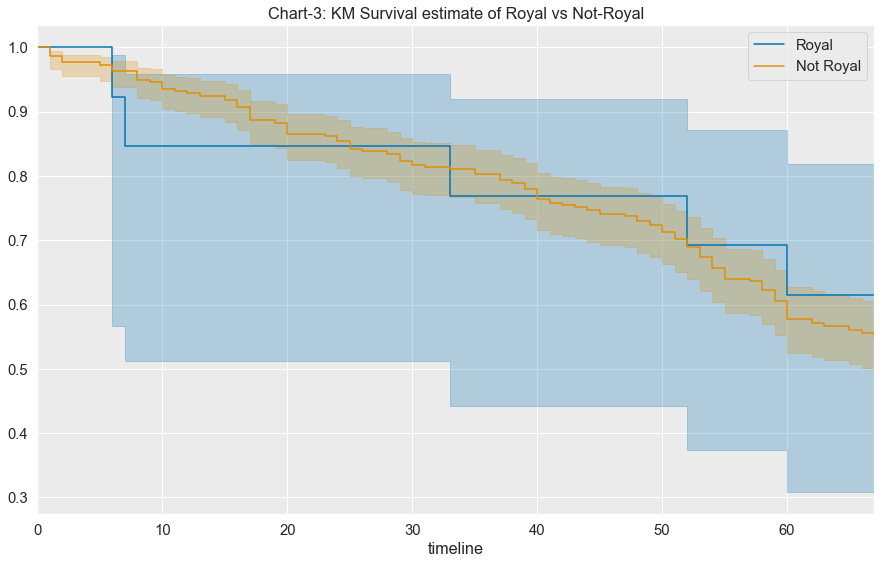

In [22]:
groups = character_df['royal']
g1 = (groups == 1)
g2 = (groups == 0)

kmf = KaplanMeierFitter()
kmf.fit(character_df['duration_in_episodes'][g1], character_df['is_dead'][g1], label='Royal')
ax = kmf.plot()

kmf.fit(character_df['duration_in_episodes'][g2], character_df['is_dead'][g2], label='Not Royal')
ax = kmf.plot(ax=ax)
ax.set_title('Chart-3: KM Survival estimate of Royal vs Not-Royal')
ax.get_figure().savefig("chart3.png")

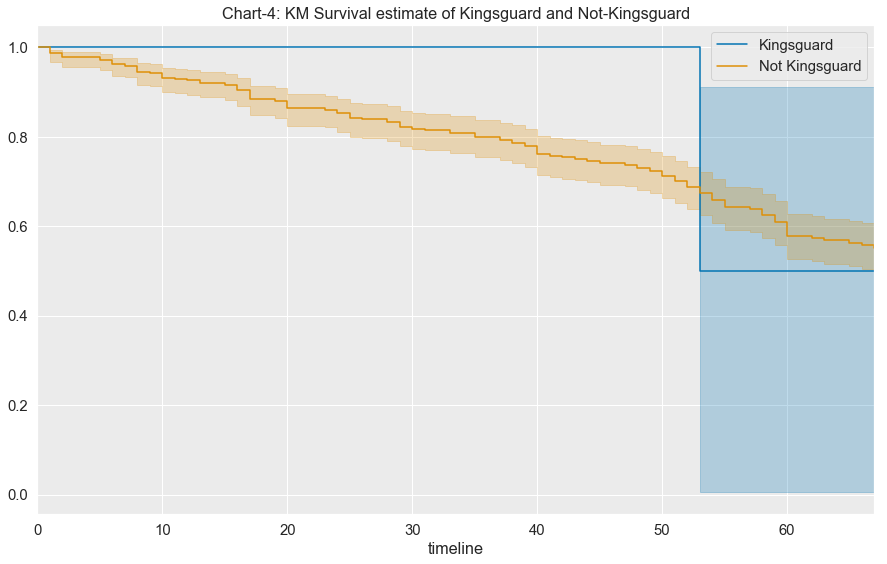

In [23]:
groups = character_df['kingsguard']
g1 = (groups == 1)
g2 = (groups == 0)

kmf = KaplanMeierFitter()
kmf.fit(character_df['duration_in_episodes'][g1], character_df['is_dead'][g1], label='Kingsguard')
ax = kmf.plot()

kmf.fit(character_df['duration_in_episodes'][g2], character_df['is_dead'][g2], label='Not Kingsguard')
ax = kmf.plot(ax=ax)
ax.set_title('Chart-4: KM Survival estimate of Kingsguard and Not-Kingsguard')
ax.get_figure().savefig("chart4.png")

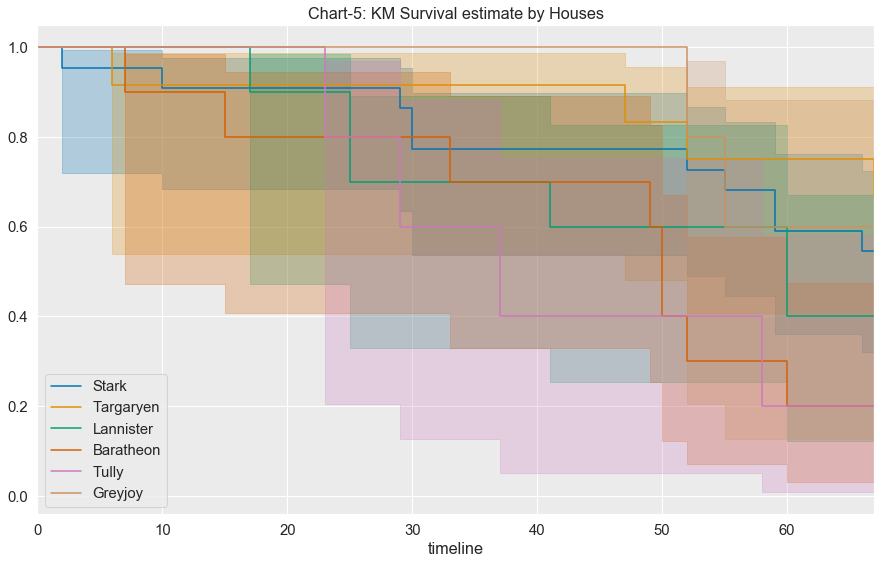

In [24]:
sns.set(palette = "colorblind", font_scale = 1.35, rc = {"figure.figsize": (15,9), "axes.facecolor": ".92"})

kmf = KaplanMeierFitter()
kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Stark'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Stark'))]['is_dead'], label='Stark')
ax = kmf.plot()

kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Targaryen'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Targaryen'))]['is_dead'], label='Targaryen')
ax = kmf.plot(ax=ax)

kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Lannister'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Lannister'))]['is_dead'], label='Lannister')
ax = kmf.plot(ax=ax)

kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Baratheon'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Baratheon'))]['is_dead'], label='Baratheon')
ax = kmf.plot(ax=ax)

kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Tully'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Tully'))]['is_dead'], label='Tully')
ax = kmf.plot(ax=ax)

kmf.fit(character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Greyjoy'))]['duration_in_episodes'], 
        character_df[(character_df.house.notnull()) & (character_df.house.str.contains('Greyjoy'))]['is_dead'], label='Greyjoy')
ax = kmf.plot(ax=ax)
ax.set_title('Chart-5: KM Survival estimate by Houses')
ax.get_figure().savefig("chart5.png")

In [12]:
# kmf_by_hou = KaplanMeierFitter()

# duration = character_df.duration_in_episodes
# observed = character_df.is_dead
# houses = ['Stark','Targaryen','Lannister','Baratheon','Tully','Greyjoy']

# fig, axes = plt.subplots(nrows = 5, ncols = 3, sharey = True,figsize=(12,15))
 
# for hou, ax in zip(houses, axes.flatten()):
#     idx = character_df.house == hou
#     kmf_by_hou.fit(duration[idx], observed[idx])
#     kmf_by_hou.plot(ax=ax, legend=False)
# #     ax.annotate("Median = {:.0f} yrs".format(kmf_by_pos.median_), xy = (.47, .85), xycoords = "axes fraction")
#     ax.set_xlabel("")
#     ax.set_title(hou)
#     ax.set_xlim(0,25)
#     ax.set_ylim(0,1)

# fig.tight_layout()

# fig.text(0.5, -0.01, "Timeline (Years)", ha="center")
# fig.text(-0.01, 0.5, "Probability That a Player is Still Active", va="center", rotation="vertical")
# fig.suptitle("Chart-5: Survival Estimates by Houses", fontsize=20)
# fig.subplots_adjust(top=0.92)

# plt.show()

In [28]:
# df_r = character_df.set_index('character_name')

df_r = character_df.drop(['character_name'], axis=1)
df_r.house = df_r.house.fillna('')
df_r['house_Stark'] = [(1 if 'Stark' in item else 0) for item in df_r['house']]
df_r['house_Lannister'] = [(1 if 'Lannister' in item else 0) for item in df_r['house']]
df_r['house_Targaryen'] = [(1 if 'Targaryen' in item else 0) for item in df_r['house']]
# df_r['house_Bolton'] = [(1 if 'Bolton' in item else 0) for item in df_r['house']]
df_r['house_Greyjoy'] = [(1 if 'Greyjoy' in item else 0) for item in df_r['house']]
df_r['house_Martell'] = [(1 if 'Martell' in item else 0) for item in df_r['house']]
df_r['house_Mormont'] = [(1 if 'Mormont' in item else 0) for item in df_r['house']]
# df_r['house_Tarly'] = [(1 if 'Tarly' in item else 0) for item in df_r['house']]
df_r['house_Tully'] = [(1 if 'Tully' in item else 0) for item in df_r['house']]
# df_r['house_Tyrell'] = [(1 if 'Tyrell' in item else 0) for item in df_r['house']]
df_r = df_r.drop(['house'], axis=1)

# removing per correlation matrix
df_r = df_r.drop(['s'+str(i)+'_ec' for i in range(1,8)], axis=1)
df_r = df_r.drop(['s'+str(i)+'_bc' for i in range(1,8)], axis=1)

# for i in range(1,8):
#     sp = 's' + str(i) + '_'
#     s_ec_min = df_r[sp+'ec'].min()
#     s_ec_max = df_r[sp+'ec'].max()
#     df_r[sp+'ec'] = df_r.apply(lambda x: (round((((100.00-10.00)*(x[sp+'ec']-s_ec_min))/(s_ec_max-s_ec_min)) + 10.00, 2) ), axis=1)

# /anaconda3/envs/dev2/lib/python3.7/site-packages/lifelines/utils/__init__.py:899: ConvergenceWarning: Column(s) ['s1_bc', 's1_pagerank', 's2_bc', 's2_pagerank', 's3_bc', 's3_pagerank', 's4_bc', 's4_pagerank', 's5_bc', 's5_pagerank', 's6_bc', 's6_pagerank', 's7_bc', 's7_pagerank'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.
#   warnings.warn(warning_text, ConvergenceWarning)

df_dummy = pd.get_dummies(df_r, drop_first=True)

# df = character_df[['character_name']]
# df_dummy = df.merge(df_dummy, how='outer', left_index=True, right_index=True)

df_dummy.head()

,royal,kingsguard,is_dead,duration_in_episodes,total_screen_time,num_of_episodes_appeared,num_of_people_killed,is_married,have_siblings,have_children,house_Stark,house_Lannister,house_Targaryen,house_Greyjoy,house_Martell,house_Mormont,house_Tully,gender_male
0,0,0,0,67,1.27,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,67,0.00,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,0,67,10.02,2,1,0,1,0,0,0,0,1,0,0,0,0
3,1,0,0,67,0.00,0,0,1,1,1,0,0,1,0,0,0,0,0
4,0,0,1,54,9.08,3,0,0,0,0,0,0,0,0,0,0,0,0


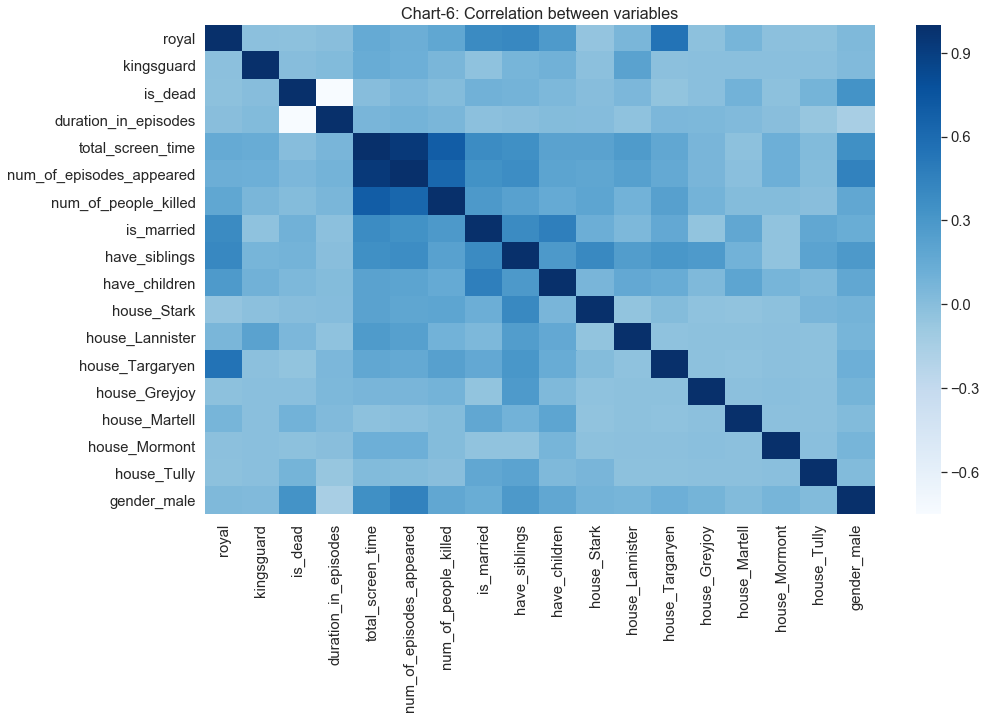

In [29]:
corr = df_dummy.corr()
# corr.style.background_gradient(cmap='coolwarm')

ax = plt.axes()
sns.heatmap(corr,ax = ax,xticklabels=corr.columns,yticklabels=corr.columns,cmap='Blues')

ax.set_title('Chart-6: Correlation between variables')
plt.show()

ax.get_figure().savefig("chart6.png")

# plot the heatmap
# sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap="Blues")
# remove ec 

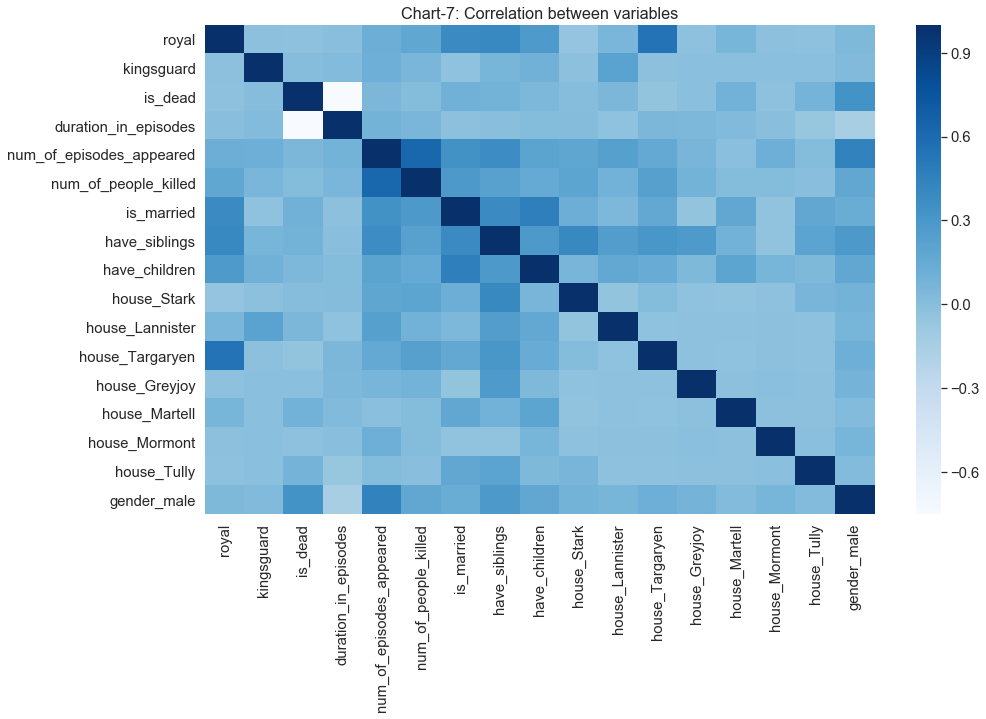

In [30]:
df_dummy = df_dummy.drop(['total_screen_time'], axis=1)
corr = df_dummy.corr()

ax = plt.axes()
sns.heatmap(corr,ax = ax,xticklabels=corr.columns,yticklabels=corr.columns,cmap='Blues')

ax.set_title('Chart-7: Correlation between variables (after removing total_screen_time)')
plt.show()

ax.get_figure().savefig("chart7.png")

In [31]:
cph = CoxPHFitter()

cph.fit(df_dummy, 'duration_in_episodes', event_col='is_dead')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 368 observations, 203 censored>
      duration col = 'duration_in_episodes'
         event col = 'is_dead'
number of subjects = 368
  number of events = 165
    log-likelihood = -906.38
  time fit was run = 2019-04-15 23:48:12 UTC

---
                          coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
royal                    -0.14      0.87      0.60 -0.23   0.81      0.30       -1.32        1.04
kingsguard                0.20      1.22      1.06  0.19   0.85      0.23       -1.88        2.28
num_of_episodes_appeared -0.03      0.97      0.01 -2.86 <0.005      7.87       -0.05       -0.01
num_of_people_killed      0.05      1.05      0.08  0.63   0.53      0.92       -0.11        0.21
is_married                0.50      1.64      0.29  1.74   0.08      3.62       -0.06        1.06
have_siblings             0.09      1.09      0.34  0.27   0.79      0.34       -0.57        0.75
have_children            -0.25      0.78  

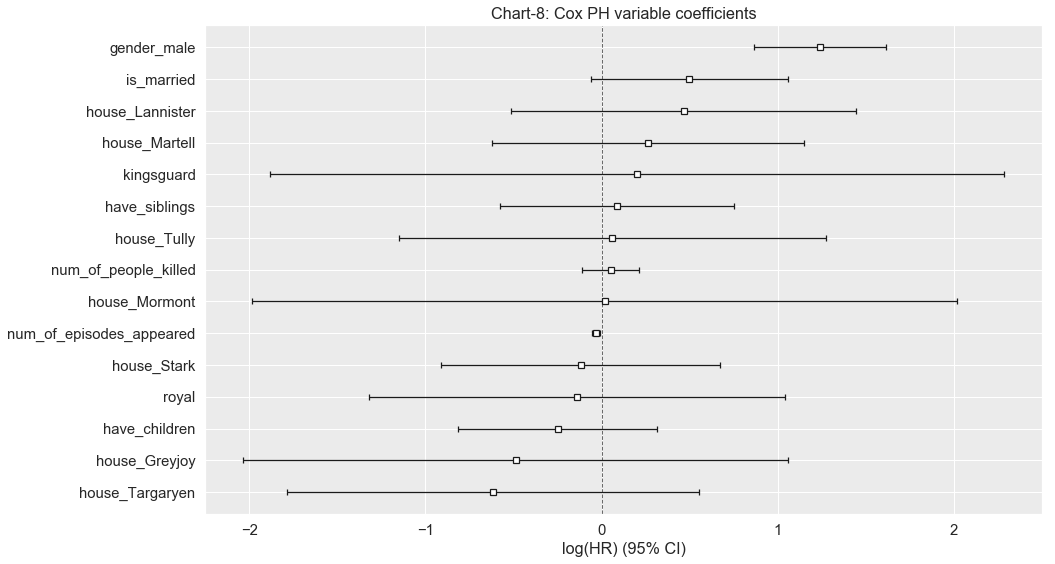

In [32]:
ax = cph.plot()
ax.set_title('Chart-8: Cox PH variable coefficients')
ax.get_figure().savefig("chart8.png")

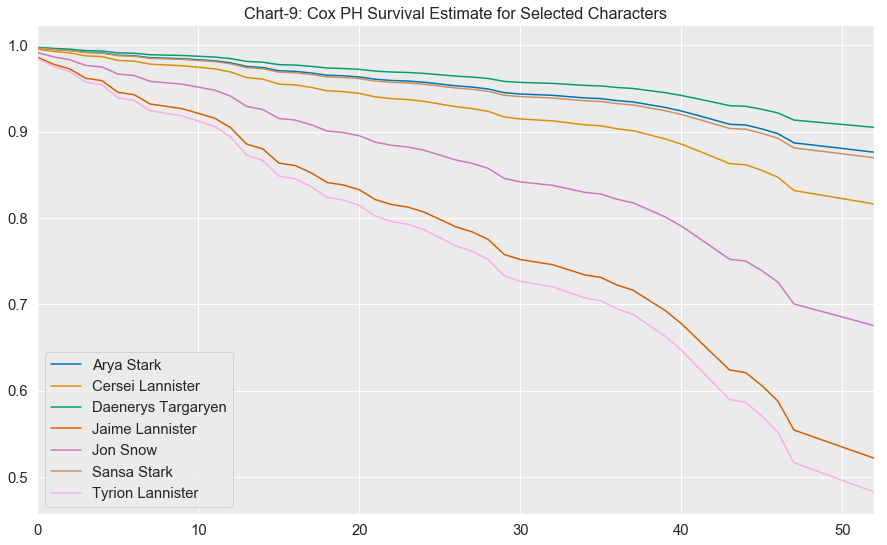

In [33]:
#tr_rows = df_dummy.iloc[10:20, ]
#tr_rows = df_dummy.iloc[character_df.index[(character_df.house.notnull()) & (character_df.house.str.contains('Stark'))].tolist(), ]

#df_dummy = df_dummy.set_index('character_name')

df2 = character_df[['character_name']]
df2 = df2.merge(df_dummy, how='outer', left_index=True, right_index=True)
tr_rows = df2[df2.character_name.isin(['Tyrion Lannister','Arya Stark','Cersei Lannister','Jaime Lannister','Jon Snow','Sansa Stark','Daenerys Targaryen'])]

tr_rows = tr_rows.set_index('character_name')
ax = cph.predict_survival_function(tr_rows).plot(use_index=False)
ax.set_title('Chart-9: Cox PH Survival Estimate for Selected Characters')
ax.get_figure().savefig("chart9.png")

# cph.predict_survival_function(tr_rows, [50,67])#.plot(use_index=False)

In [34]:
cph.predict_cumulative_hazard(tr_rows,[67])

Arya Stark            0.132023
Cersei Lannister      0.202961
Daenerys Targaryen    0.099697
Jaime Lannister       0.650439
Jon Snow              0.392554
Sansa Stark           0.139358
Tyrion Lannister      0.728272
Name: 67, dtype: float64

In [35]:
cph.predict_survival_function(tr_rows, [67])#.plot(use_index=False)

Arya Stark            0.876321
Cersei Lannister      0.816310
Daenerys Targaryen    0.905112
Jaime Lannister       0.521817
Jon Snow              0.675330
Sansa Stark           0.869917
Tyrion Lannister      0.482743
Name: 67, dtype: float64